In [1]:
# imports
import torch
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from v_prism import full_VPRISM_method
from v_prism.data_loading.bullet_reconstruction_dataset import download_vprism_ycb_dataset
from v_prism.data_loading.bullet_reconstruction_dataset import ReconBulletDataset
from v_prism.utils.ui import abspath, mkdir_if_not_exists
from v_prism.utils.visualization import gen_image_of_trimesh_scene, gen_mesh_for_sdf_batch_3d
from v_prism.utils.subsample import grid_subsample

In [2]:
# define constants

data_dir = abspath("~/data")  # change this with your data dir
device = torch.device("cuda")  # change with your chosen device
dataset_idx = 20  # whatever index you want

print(f"using device: {device}!")

using device: cuda!


In [3]:
# download dataset and make dataset object
mkdir_if_not_exists(data_dir)
download_vprism_ycb_dataset(data_dir)

dataset = ReconBulletDataset("vprism_ycb_100", data_dir=data_dir)

scene = dataset[dataset_idx]


Extracting downloading vprism_ycb_100 .tar.xz file


extracting file:   0%|          | 0/2202 [00:00<?, ?it/s]

extracting file: 100%|██████████| 2202/2202 [00:03<00:00, 633.70it/s]


In [4]:
# fit map
num_classes = int(torch.amax(scene.seg_mask).item()) + 1

vprism_map = full_VPRISM_method(
    points=scene.points,
    seg_mask=scene.seg_mask,
    num_classes=num_classes,
    camera_pos=scene.camera_pos,
    device=device
)

print(f"map has {vprism_map.hinge_points.shape[0]} hinge points!")

map has 702 hinge points!


100%|██████████| 49/49 [00:07<00:00,  6.35it/s]


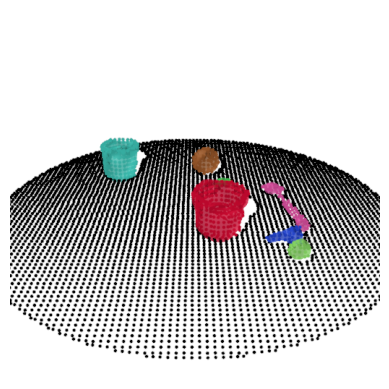

In [5]:
# display map

pointclouds = []
meshes = []
for id in range(1, num_classes):
    color = np.random.random(4)
    color[3] = 0.8
    points_id = scene.points[scene.seg_mask == id]
    maxs = torch.amax(points_id, dim=0)
    mins = torch.amin(points_id, dim=0)
    mesh = gen_mesh_for_sdf_batch_3d(
        lambda x: vprism_map.predict(x.to(device))[:, id].to(torch.device("cpu")),
        xlim=[mins[0] - 0.2, maxs[0] + 0.2],
        ylim=[mins[1] - 0.2, maxs[1] + 0.2],
        zlim=[mins[2] - 0.2, maxs[2] + 0.2],
        resolution=0.01
    )
    if mesh is not None:
        mesh.visual.vertex_colors = color
        meshes.append(mesh)
    points_subsampled, _ = grid_subsample(points_id, torch.zeros(points_id.shape[0], dtype=torch.int64), subsample_grid_size=0.01)
    pc = trimesh.PointCloud(points_subsampled)
    color[3] = 1.0
    pc.visual.vertex_colors = color
    pointclouds.append(pc)
scene_maxs = torch.amax(scene.points[scene.seg_mask > 0], dim=0)
scene_mins = torch.amin(scene.points[scene.seg_mask > 0], dim=0)
scene_center = 0.5 * (scene_maxs + scene_mins)
points_table = scene.points[scene.seg_mask == 0]
points_table = points_table[torch.norm(points_table - scene_center, dim=1) <= 0.4]
points_subsampled, _ = grid_subsample(points_table, torch.zeros(points_table.shape[0], dtype=torch.int64), subsample_grid_size=0.01)
pointclouds.append(trimesh.PointCloud(points_subsampled))

img = gen_image_of_trimesh_scene(
    scene=trimesh.Scene([*meshes, *pointclouds]),
    theta=0.0,
    rho=0.9,
    line_settings={"point_size": 5}
)

plt.imshow(img)
plt.axis("off")
plt.show()
